In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
import time as timestamp 
import importlib

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [5]:
#--------------------------------------------------
# START USER PARAMETERS
#--------------------------------------------------
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january
# nyearstrain = 30
# ntrain = int(nyearstrain*12)
# nvalid = int(38*12)
# nyearsvalid = 38-nyearstrain
# nvalidtimes = 1872

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','tos','sit','sic']
#limvars = ['sic']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'satellite'
train_dsource = 'cmip6_mpi_hist'
#train_dsource ='cmip6_mpi_hist_ssp585'
# train_dsource = 'mpi_hist_kb'
#train_dsource = 'ccsm4_lm_kb'
#valid_dsource = 'satellite'
#valid_dsource = 'cmip6_mpi_hist'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False

date_of_interest = '20210826'

In [6]:
if 'hist_ssp585' in train_dsource: 
    folder_add = 'hist_ssp585_concatenated/'
elif 'hist' in train_dsource: 
    folder_add = 'historical/'
elif 'lm' in train_dsource: 
    folder_add = 'last_millennium/'

In [21]:
# Start with truncated training data: 
#mod_folder = 'truncated_model_data/last_millennium/'
mod_folder = 'truncated_model_data/'+folder_add
#mod_filename = '_ntrunc30_mpi_lm_kb_20210503.pkl'
#mod_filename = '_ntrunc30_monthall_ccsm4_hist_kb_20210507_ntrain1_standtest.pkl'
# mod_filename = '_ntrunc30_monthall_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_filename = '_ntrunc'+str(ntrunc)+'_monthall_cmip6_mpi_hist_20210819_ntrain_1850_1999_standtest.pkl'
#mod_filename = '_ntrunc'+str(ntrunc)+'_monthall_mpi_hist_kb_20210824_ntrain_1850_1999_standtest.pkl'
mod_filename = ('_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+
                '_ntrain_1850_2004_20210916.pkl')
# mod_filename = ('_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+'_'+date_of_interest+
#                 '_ntrain_1850_2050_standtest.pkl')

#mod_filename = '_ntrunc30_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210406.pkl'
#mod_sic_filename = '_ntrunc50_monthall_ccsm4_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_monthall_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_monthall_cmip6_mpi_hist_20210819_ntrain_1850_1999_standtest.pkl'
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_monthall_mpi_hist_kb_20210824_ntrain_1850_1999_standtest.pkl'
# mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_monthall_mpi_hist_kb_'+date_of_interest+
#                     '_ntrain_1850_2005_standtest.pkl')
mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+
                    '_ntrain_1850_2004_20210916.pkl')
# mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+'_'+date_of_interest+
#                     '_ntrain_1850_2050_standtest.pkl')

#mod_sic_filename = '_ntrunc50_month0_mpi_hist_kb_20210727_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
train_dsource = 'cmip6_mpi_hist'

In [30]:
exp_setup = {}
exp_setup['mo'] = mo
exp_setup['tau'] = tau
exp_setup['ntrunc'] = ntrunc 
exp_setup['nmodes_sic'] = nmodes_sic
exp_setup['limvars'] = limvars
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 
exp_setup['sic_separate'] = sic_separate
exp_setup['Insamp'] = Insamp
exp_setup['mod_folder'] = mod_folder
exp_setup['mod_filename'] = mod_filename
exp_setup['mod_sic_filename'] = mod_sic_filename
exp_setup['Weight'] = True
exp_setup['nyearsvalid'] = 100
exp_setup['nyearstot'] = 1000
exp_setup['nyears_startvalid'] = 900*12
exp_setup['ntrain']=((exp_setup['nyearstot']*12)-(exp_setup['nyearsvalid'] *12))/(exp_setup['nyearstot']*12)

In [31]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [32]:
import run_forecast_model_data as rf

In [33]:
importlib.reload(rf)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [34]:
master_save = False

In [35]:
#--------------------------------------------------
### Build L from truncated data: 
#--------------------------------------------------

save_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

LIMd = rf.build_L(exp_setup, save_folder, save=master_save)

Loading truncated tas
Loading truncated tos
Loading truncated sit
Loading truncated sic
working on tas
working on tos
working on sit
working on sic
0, tas
1, tos
2, sit
Training LIM with tau = 1
Number of positive eigenvalues = 0.0


In [36]:
#--------------------------------------------------
### Load pre-build L: 
#--------------------------------------------------
L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
L_filename = 'L_'+train_dsource+'_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl'

LIMd = pickle.load(open(L_folder+L_filename, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/L_cmip6_mpi_hist_ntrain_1850_2005_tas30_tos30_sit30_sic50_20210826.pkl'

In [37]:
LIMd.keys()


dict_keys(['vec', 'veci', 'val', 'lam_L', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup'])

## Run Forecast: 

In [38]:
lags = [0,1,2,3,4,5,6]

if LIMd['npos_eigenvalues'] >0: 
    adj = True
else: 
    adj = False

exp_setup['lags'] = lags
exp_setup['adj'] = adj
exp_setup['remove_climo'] = True
exp_setup['detrend'] = True
exp_setup['nyr_train'] = None
exp_setup['Insamp'] = Insamp

f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

In [39]:
forecast = rf.run_forecast(LIMd,exp_setup, f_folder, verbose=True, save=master_save, save_decomp=False)

Validation data: mpi_lm_kb
tecut = 1000, tscut = 900.0
Loading from tas
Loading from t_millenium/tas_sfc_Amon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 17.248485565185547 seconds
-----------------------------------------------------
Validation shape: (18432, 1200)
time dimension: 1750 - 1849
(1200,)
tecut = 1000, tscut = 900.0
Loading from tos
Loading from t_millenium/tos_sfc_Omon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on mo

In [ ]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = 'Forecast_'+train_dsource+'_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl'

# forecast = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from torical/areacella_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from orical/areacello_Ofx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
tecut = 1000, tscut = 900.0
Loading from tas
Loading from t_millenium/tas_sfc_Amon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 17.58611273765564 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


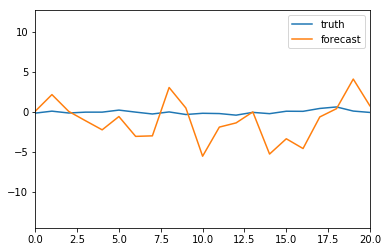

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


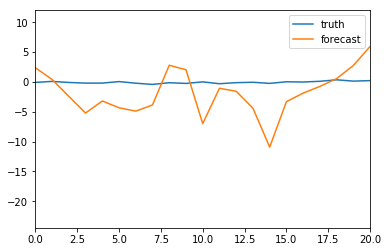

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


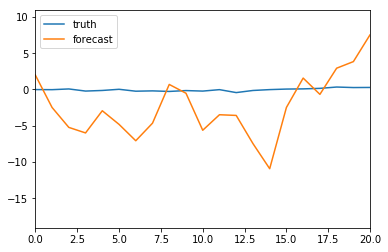

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


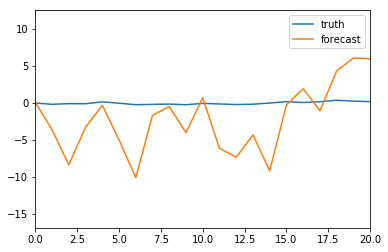

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


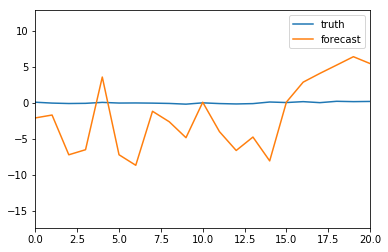

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


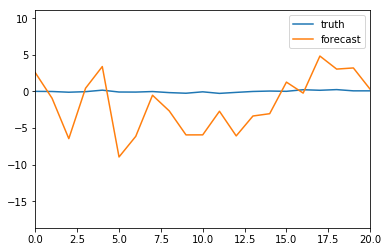

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


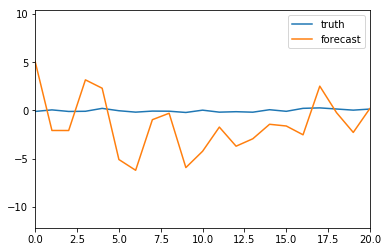

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


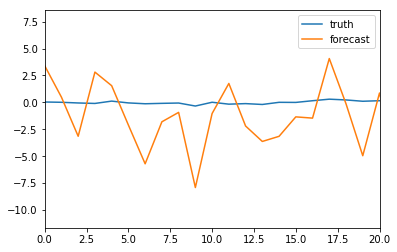

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


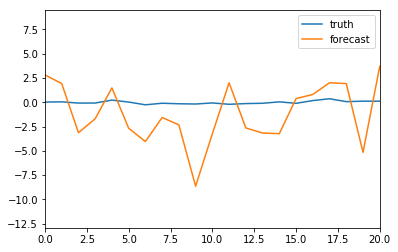

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


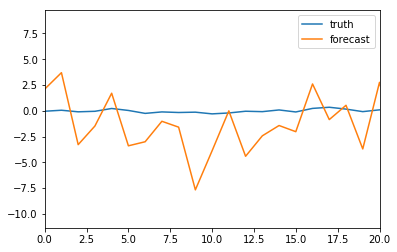

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)
changing cellarea units from m2 to km^2


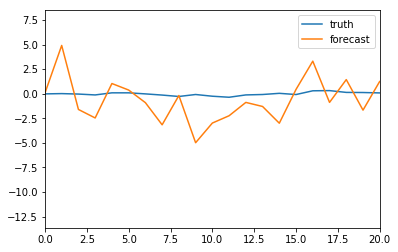

tecut = 1000, tscut = 900.0
Loading from tos
Loading from t_millenium/tos_sfc_Omon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 52.953197956085205 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


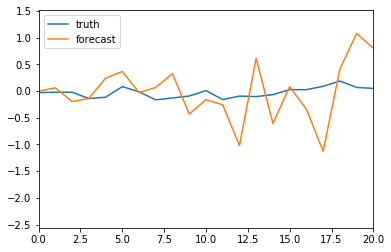

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


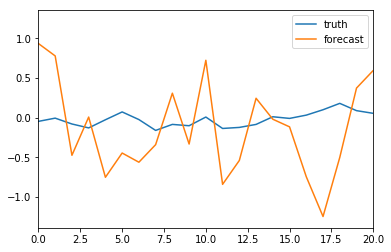

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


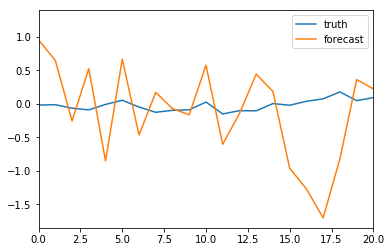

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


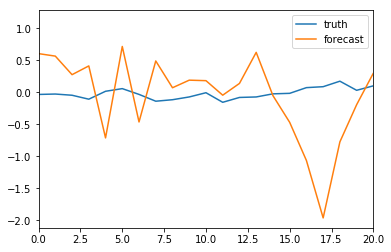

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


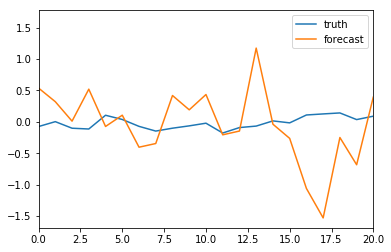

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


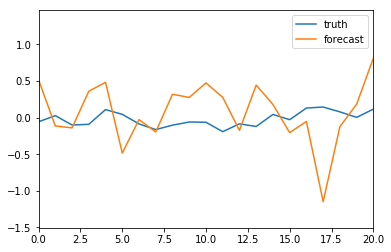

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


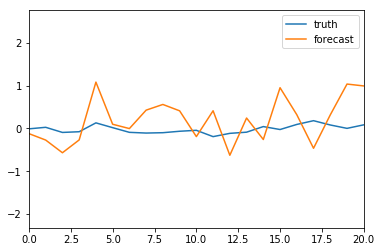

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


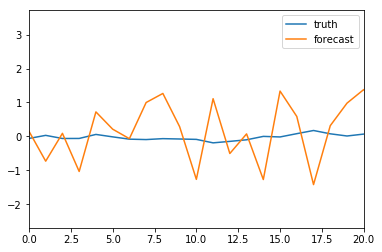

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


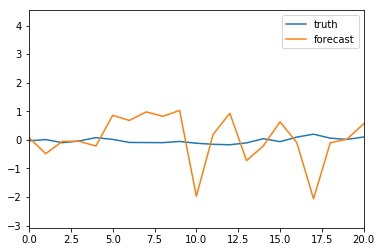

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


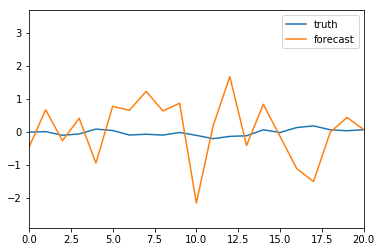

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


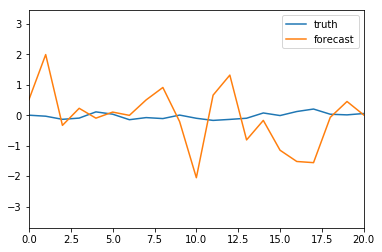

tecut = 1000, tscut = 900.0
Loading from sit
Loading from ceData/MPI/sit_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 75.14334344863892 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


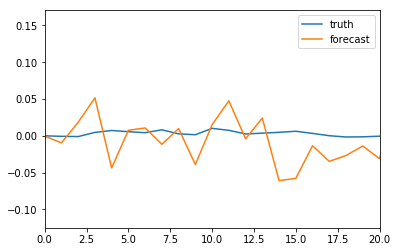

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


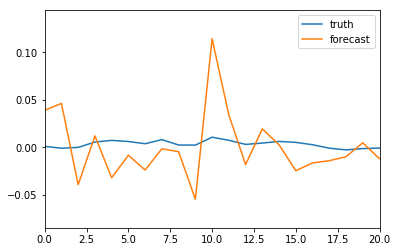

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


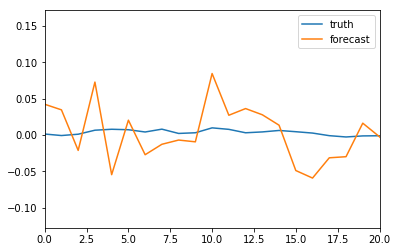

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


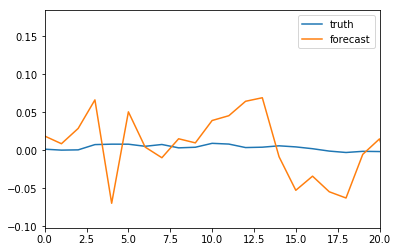

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


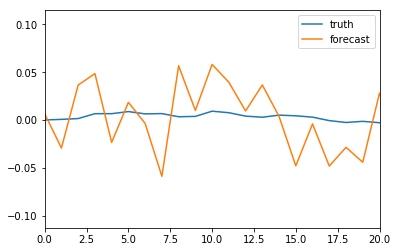

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


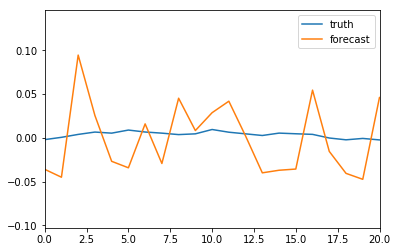

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


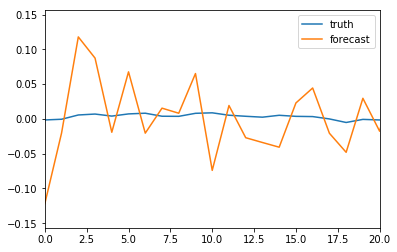

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


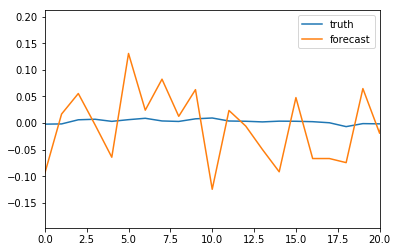

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


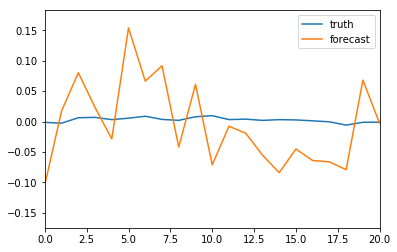

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


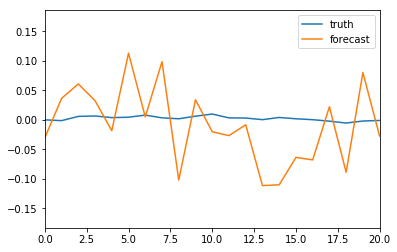

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2


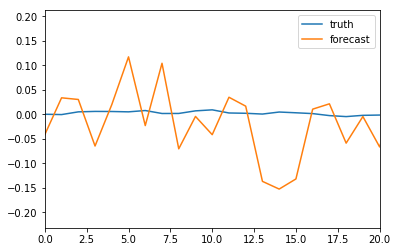

tecut = 1000, tscut = 900.0
Loading from sic
Loading from ceData/MPI/sic_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 53.468350410461426 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 83.9 ...dividing concentration by 100.
Max concentration is 92.02 ...dividing concentration by 100.


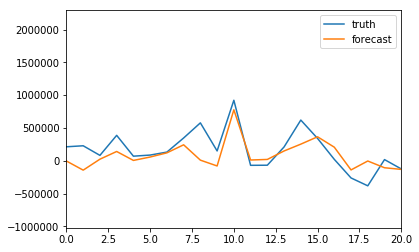

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 126.08 ...dividing concentration by 100.
Max concentration is 90.8 ...dividing concentration by 100.


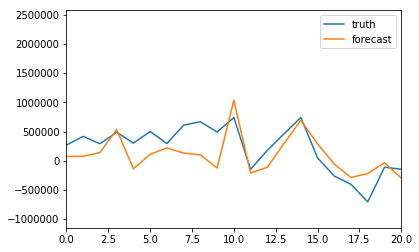

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 119.82 ...dividing concentration by 100.
Max concentration is 93.28 ...dividing concentration by 100.


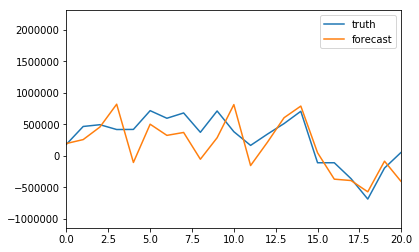

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 103.63 ...dividing concentration by 100.
Max concentration is 95.14 ...dividing concentration by 100.


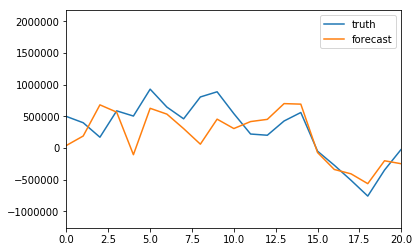

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 104.7 ...dividing concentration by 100.
Max concentration is 92.35 ...dividing concentration by 100.


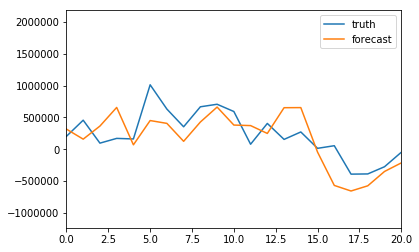

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 108.91 ...dividing concentration by 100.
Max concentration is 88.49 ...dividing concentration by 100.


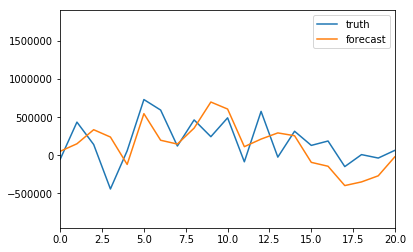

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 57.84 ...dividing concentration by 100.
Max concentration is 81.27 ...dividing concentration by 100.


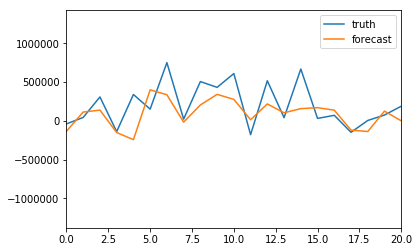

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 56.39 ...dividing concentration by 100.
Max concentration is 89.22 ...dividing concentration by 100.


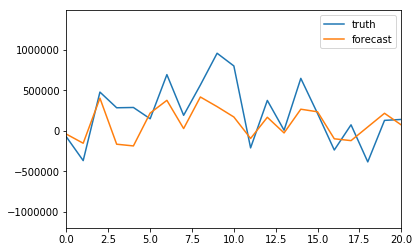

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 67.25 ...dividing concentration by 100.
Max concentration is 88.21 ...dividing concentration by 100.


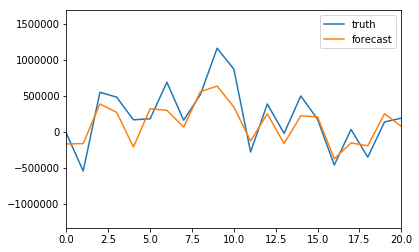

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 71.79 ...dividing concentration by 100.
Max concentration is 89.31 ...dividing concentration by 100.


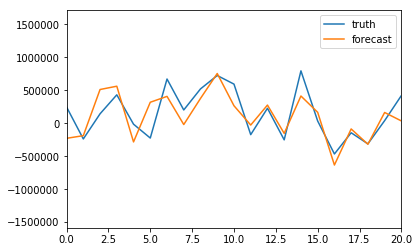

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)
changing cellarea units from m2 to km^2
Max concentration is 71.84 ...dividing concentration by 100.
Max concentration is 88.54 ...dividing concentration by 100.


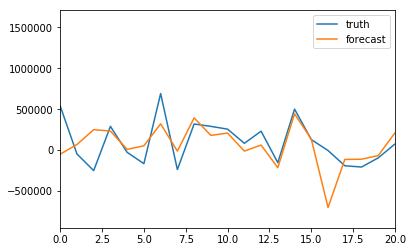

In [40]:
forecast_validation = rf.validate_forecast_monthly(forecast, exp_setup['limvars'], 1, exp_setup, LIMd, f_folder, 
                                                   iplot=True, save=master_save)

In [41]:
# L_filename = ('Forecast_validation_'+train_dsource+
#               '_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl')

# L_filename = ('Forecast_validation_cmip6_mpi_hist_ntrain_1850_2005_validation_mpi_lm_kb'+
#               '_0_100_tas30_tos30_sit30_sic50_20210826.pkl')

# forecast_validation_monthly = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from torical/areacella_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from orical/areacello_Ofx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
tecut = 1000, tscut = 900.0
Loading from tas
Loading from t_millenium/tas_sfc_Amon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 17.755605220794678 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (18432, 1200)
Forecast_anom shape: (18432, 1200)
changing cellarea units from m2 to km^2


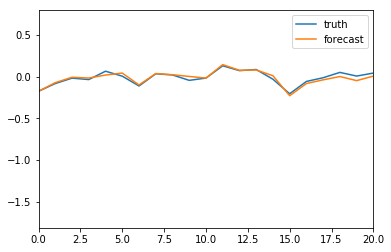

Lag 1
Trained using all months...
Truth_anom shape: (18432, 1199)
Forecast_anom shape: (18432, 1199)
changing cellarea units from m2 to km^2


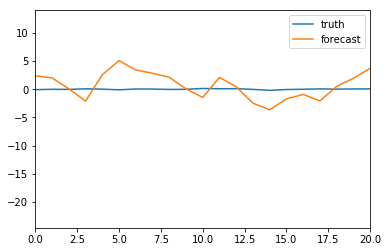

Lag 2
Trained using all months...
Truth_anom shape: (18432, 1198)
Forecast_anom shape: (18432, 1198)
changing cellarea units from m2 to km^2


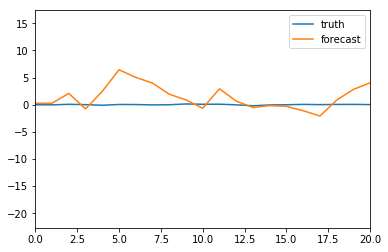

Lag 3
Trained using all months...
Truth_anom shape: (18432, 1197)
Forecast_anom shape: (18432, 1197)
changing cellarea units from m2 to km^2


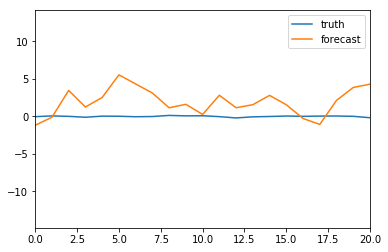

Lag 4
Trained using all months...
Truth_anom shape: (18432, 1196)
Forecast_anom shape: (18432, 1196)
changing cellarea units from m2 to km^2


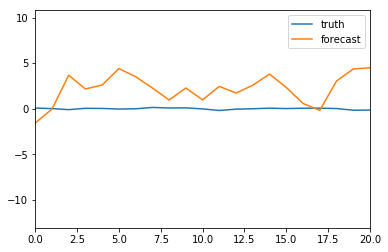

Lag 5
Trained using all months...
Truth_anom shape: (18432, 1195)
Forecast_anom shape: (18432, 1195)
changing cellarea units from m2 to km^2


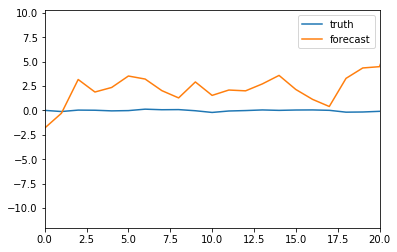

Lag 6
Trained using all months...
Truth_anom shape: (18432, 1194)
Forecast_anom shape: (18432, 1194)
changing cellarea units from m2 to km^2


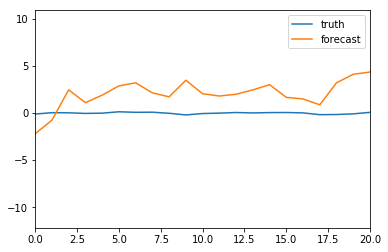

tecut = 1000, tscut = 900.0
Loading from tos
Loading from t_millenium/tos_sfc_Omon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 53.897618770599365 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (56320, 1200)
Forecast_anom shape: (56320, 1200)
changing cellarea units from m2 to km^2


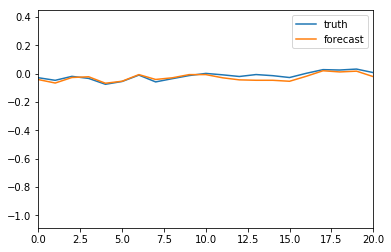

Lag 1
Trained using all months...
Truth_anom shape: (56320, 1199)
Forecast_anom shape: (56320, 1199)
changing cellarea units from m2 to km^2


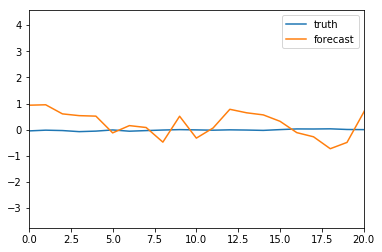

Lag 2
Trained using all months...
Truth_anom shape: (56320, 1198)
Forecast_anom shape: (56320, 1198)
changing cellarea units from m2 to km^2


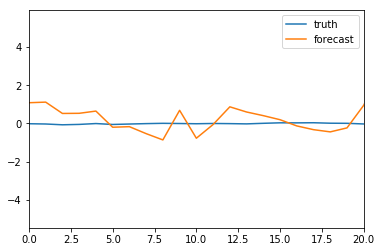

Lag 3
Trained using all months...
Truth_anom shape: (56320, 1197)
Forecast_anom shape: (56320, 1197)
changing cellarea units from m2 to km^2


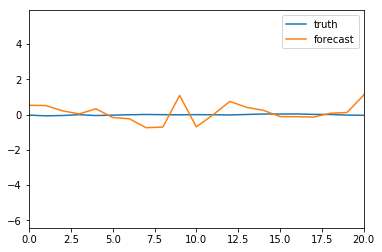

Lag 4
Trained using all months...
Truth_anom shape: (56320, 1196)
Forecast_anom shape: (56320, 1196)
changing cellarea units from m2 to km^2


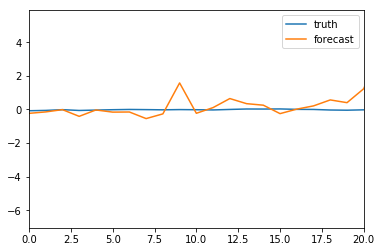

Lag 5
Trained using all months...
Truth_anom shape: (56320, 1195)
Forecast_anom shape: (56320, 1195)
changing cellarea units from m2 to km^2


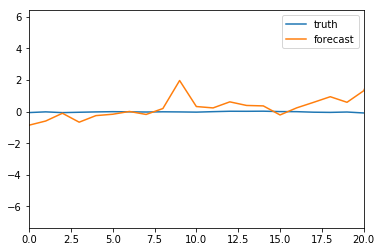

Lag 6
Trained using all months...
Truth_anom shape: (56320, 1194)
Forecast_anom shape: (56320, 1194)
changing cellarea units from m2 to km^2


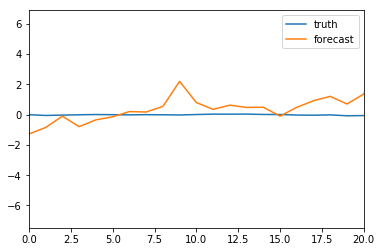

tecut = 1000, tscut = 900.0
Loading from sit
Loading from ceData/MPI/sit_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 53.868242025375366 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (56320, 1200)
Forecast_anom shape: (56320, 1200)
changing cellarea units from m2 to km^2


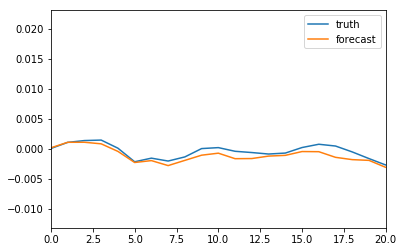

Lag 1
Trained using all months...
Truth_anom shape: (56320, 1199)
Forecast_anom shape: (56320, 1199)
changing cellarea units from m2 to km^2


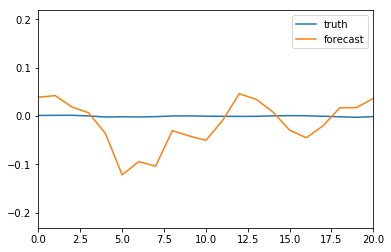

Lag 2
Trained using all months...
Truth_anom shape: (56320, 1198)
Forecast_anom shape: (56320, 1198)
changing cellarea units from m2 to km^2


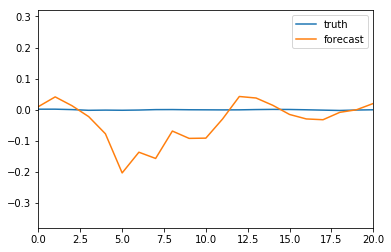

Lag 3
Trained using all months...
Truth_anom shape: (56320, 1197)
Forecast_anom shape: (56320, 1197)
changing cellarea units from m2 to km^2


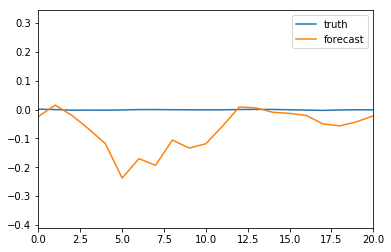

Lag 4
Trained using all months...
Truth_anom shape: (56320, 1196)
Forecast_anom shape: (56320, 1196)
changing cellarea units from m2 to km^2


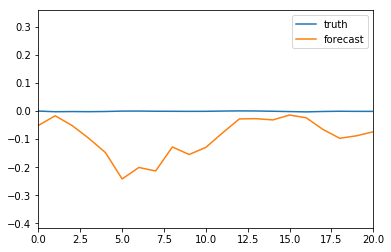

Lag 5
Trained using all months...
Truth_anom shape: (56320, 1195)
Forecast_anom shape: (56320, 1195)
changing cellarea units from m2 to km^2


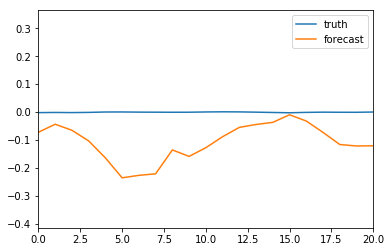

Lag 6
Trained using all months...
Truth_anom shape: (56320, 1194)
Forecast_anom shape: (56320, 1194)
changing cellarea units from m2 to km^2


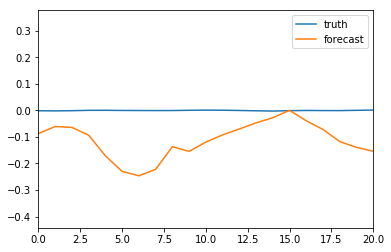

tecut = 1000, tscut = 900.0
Loading from sic
Loading from ceData/MPI/sic_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 1750 - 1849
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 52.78497242927551 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (56320, 1200)
Forecast_anom shape: (56320, 1200)
changing cellarea units from m2 to km^2
Max concentration is 108.34 ...dividing concentration by 100.
Max concentration is 95.14 ...dividing concentration by 100.


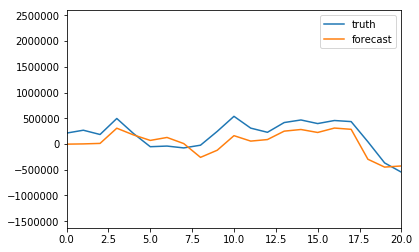

Lag 1
Trained using all months...
Truth_anom shape: (56320, 1199)
Forecast_anom shape: (56320, 1199)
changing cellarea units from m2 to km^2
Max concentration is 126.07 ...dividing concentration by 100.
Max concentration is 95.14 ...dividing concentration by 100.


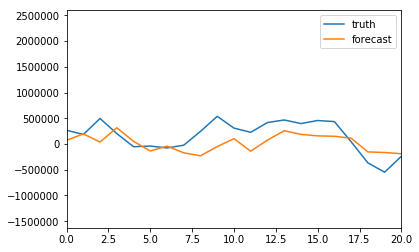

Lag 2
Trained using all months...
Truth_anom shape: (56320, 1198)
Forecast_anom shape: (56320, 1198)
changing cellarea units from m2 to km^2
Max concentration is 120.45 ...dividing concentration by 100.
Max concentration is 95.17 ...dividing concentration by 100.


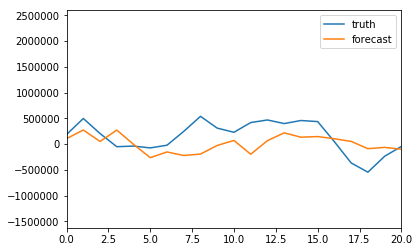

Lag 3
Trained using all months...
Truth_anom shape: (56320, 1197)
Forecast_anom shape: (56320, 1197)
changing cellarea units from m2 to km^2
Max concentration is 91.29 ...dividing concentration by 100.
Max concentration is 95.22 ...dividing concentration by 100.


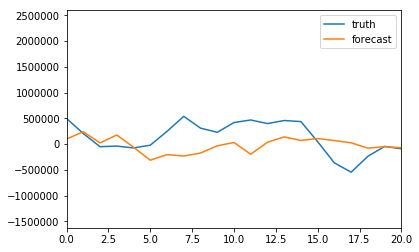

Lag 4
Trained using all months...
Truth_anom shape: (56320, 1196)
Forecast_anom shape: (56320, 1196)
changing cellarea units from m2 to km^2
Max concentration is 59.19 ...dividing concentration by 100.
Max concentration is 95.25 ...dividing concentration by 100.


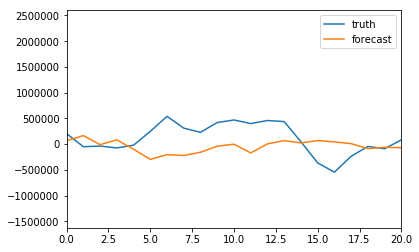

Lag 5
Trained using all months...
Truth_anom shape: (56320, 1195)
Forecast_anom shape: (56320, 1195)
changing cellarea units from m2 to km^2
Max concentration is 36.21 ...dividing concentration by 100.
Max concentration is 95.26 ...dividing concentration by 100.


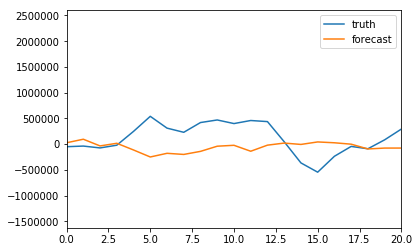

Lag 6
Trained using all months...
Truth_anom shape: (56320, 1194)
Forecast_anom shape: (56320, 1194)
changing cellarea units from m2 to km^2
Max concentration is 27.37 ...dividing concentration by 100.
Max concentration is 95.26 ...dividing concentration by 100.


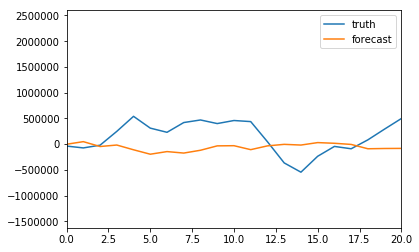

In [42]:
forecast_validation_lags = rf.validate_forecast_lagged(forecast, exp_setup['limvars'], exp_setup, LIMd, 
                                                       f_folder, iplot=True, save=master_save)

In [42]:
# L_filename = ('Forecast_validation_lagged_'+train_dsource+
#               '_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl')

# L_filename = ('Forecast_validation_lagged_cmip6_mpi_hist_ntrain_1850_2005_validation_mpi_lm_kb'+
#               '_0_100_tas30_tos30_sit30_sic50_20210826.pkl')

# forecast_validation_lags = pickle.load(open(L_folder+L_filename, 'rb'))

## Run AR1 Forecast: 

Loading from torical/areacella_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from orical/areacello_Ofx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from tas
Loading from t_millenium/tas_sfc_Amon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(18432, 1200)
(18432, 1200)
-----------------------------------------------------
completed in 2.074007034301758 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


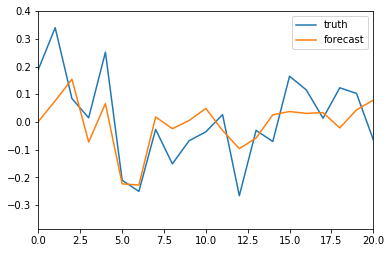

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


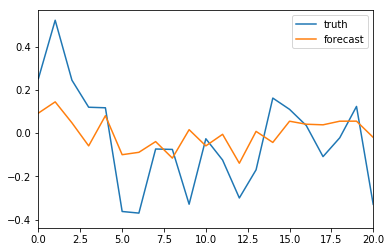

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


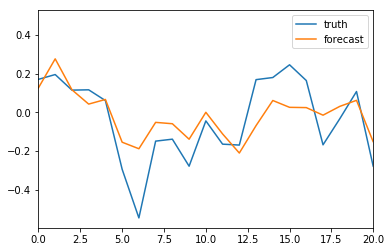

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


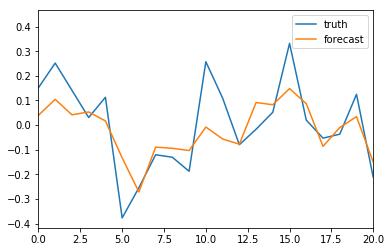

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


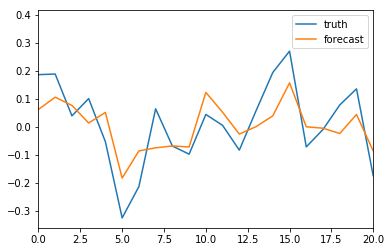

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


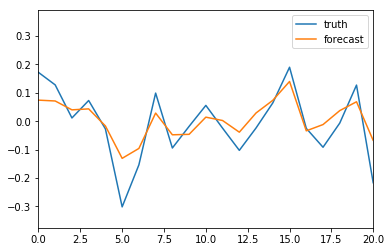

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


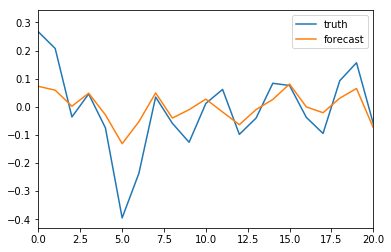

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


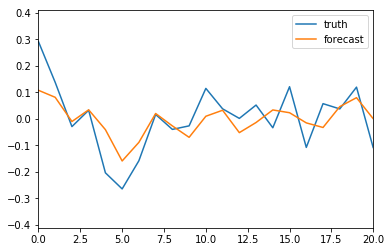

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


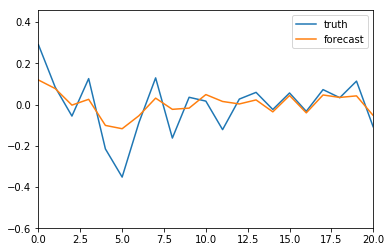

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


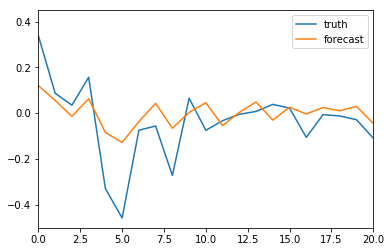

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 100)
Forecast_anom shape: (18432, 100)


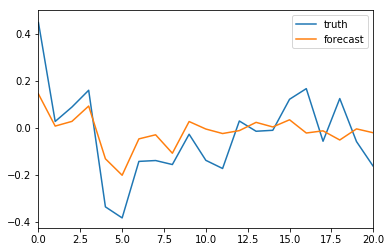

Loading from tos
Loading from t_millenium/tos_sfc_Omon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(56320, 1200)
(56320, 1200)
-----------------------------------------------------
completed in 5.962459087371826 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


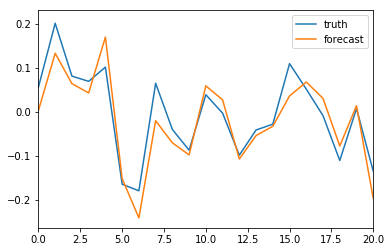

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


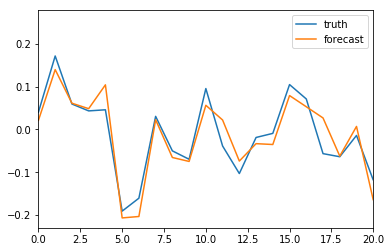

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


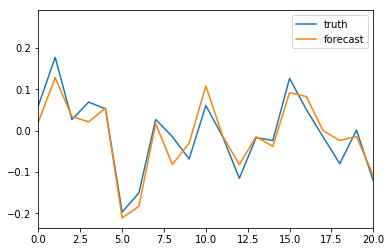

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


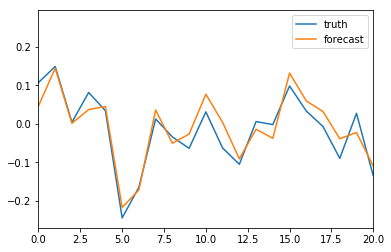

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


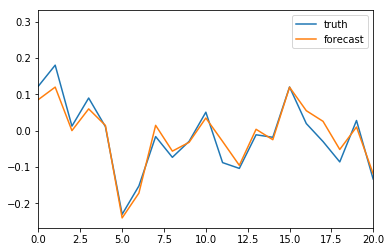

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


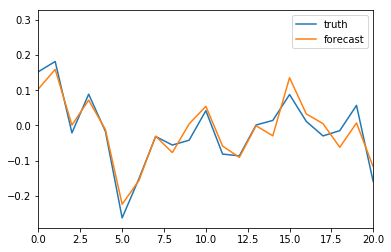

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


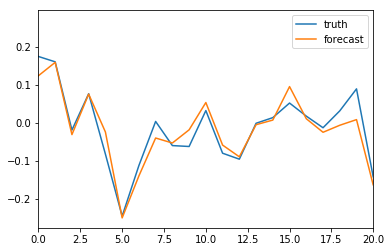

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


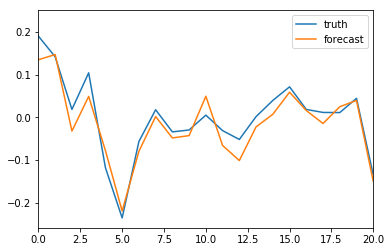

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


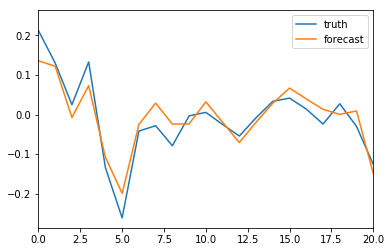

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


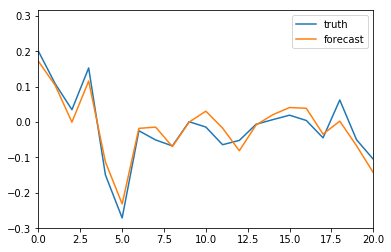

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


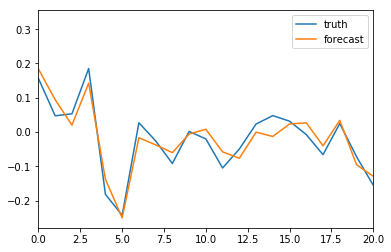

Loading from sit
Loading from ceData/MPI/sit_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(56320, 1200)
(56320, 1200)
-----------------------------------------------------
completed in 5.786583423614502 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


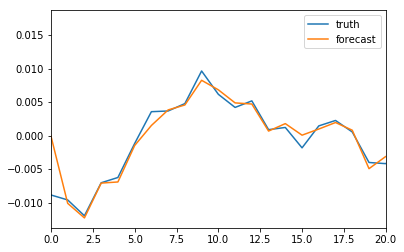

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


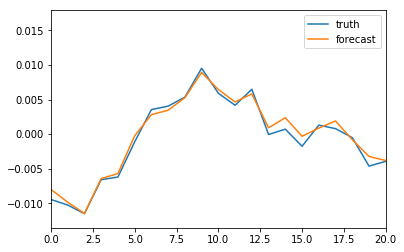

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


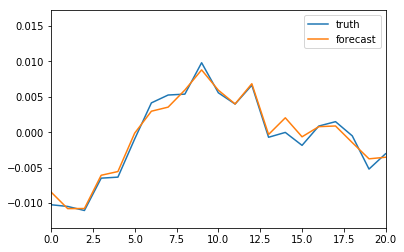

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


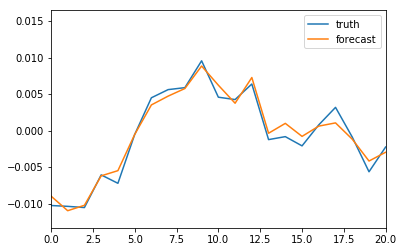

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


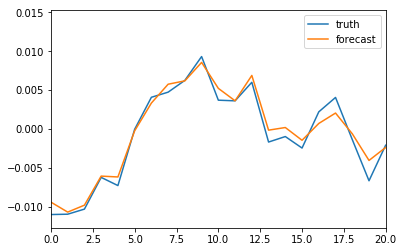

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


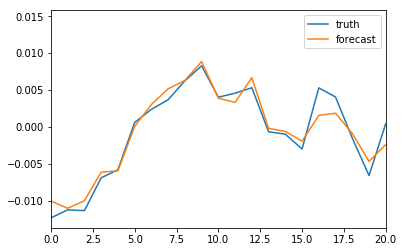

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


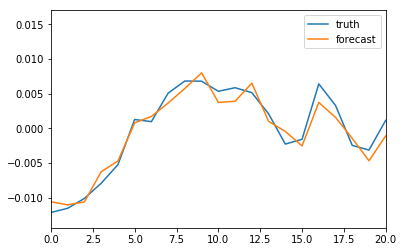

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


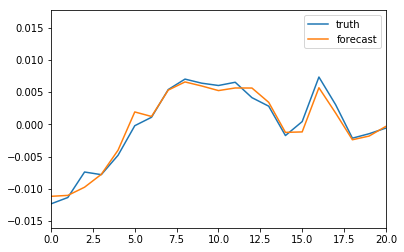

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


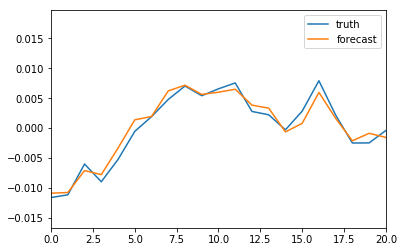

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


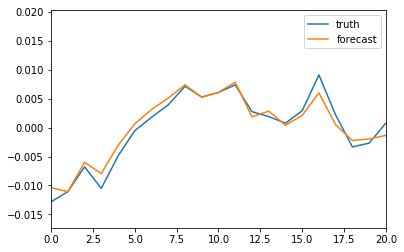

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


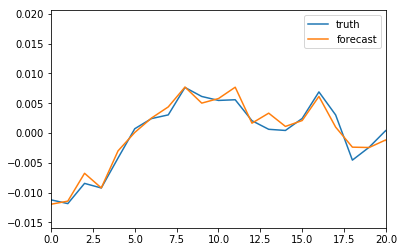

Loading from sic
Loading from ceData/MPI/sic_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(56320, 1200)
(56320, 1200)
-----------------------------------------------------
completed in 5.846120595932007 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


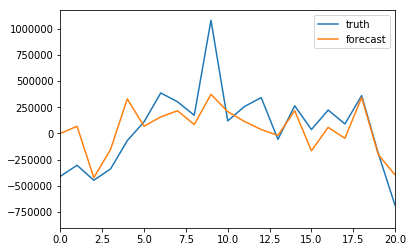

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


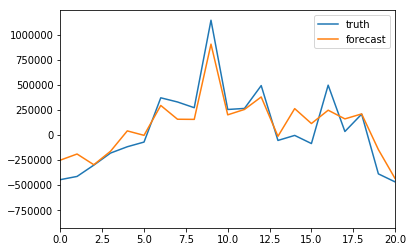

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


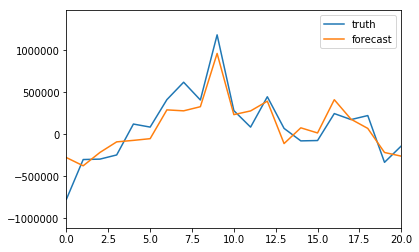

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


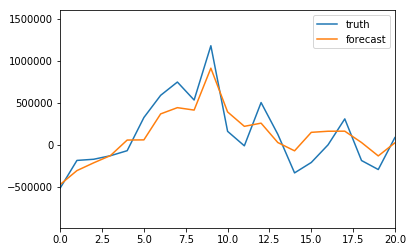

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


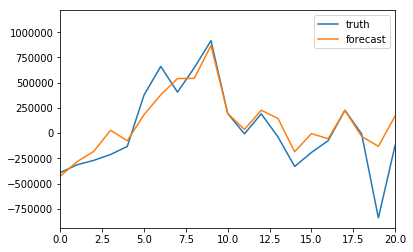

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


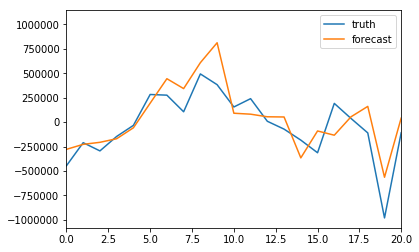

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


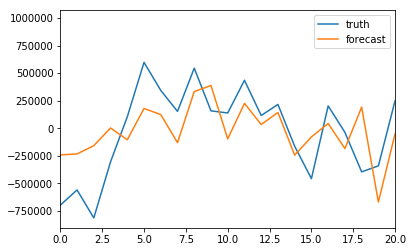

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


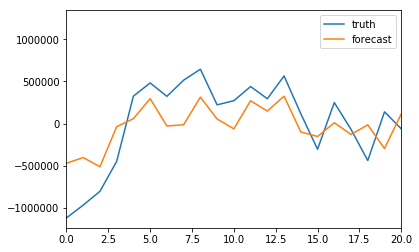

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


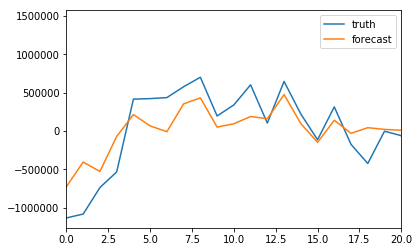

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


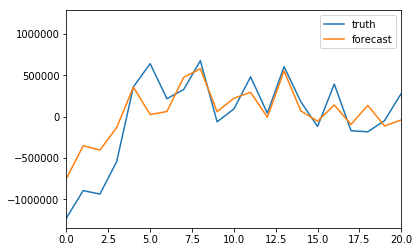

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 100)
Forecast_anom shape: (56320, 100)


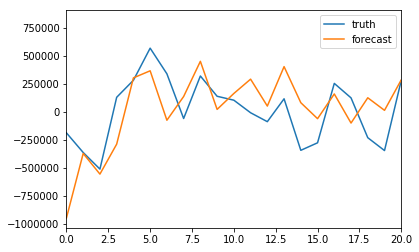

In [43]:
valid_vars=limvars
ar1f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

ar1cast = rf.ar1_forecast_valid_by_month(LIMd['P_train'], forecast['P_train_valid'], LIMd,
                                         exp_setup, valid_vars, month_names, ar1f_folder, forecast,
                                         lag=None, iplot=True, save=master_save, save_decomp=False)

In [44]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = ('AR1_forecast_monthly_'+train_dsource+
#               '_ntrain_1850_1999_tas30_tos30_psl30_sit30_sic50_'+date_of_interest+'.pkl')

# ar1cast = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from torical/areacella_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from orical/areacello_Ofx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from tas
Loading from t_millenium/tas_sfc_Amon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(18432, 1200)
(18432, 1200)
-----------------------------------------------------
completed in 9.141837358474731 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (18432, 1200)
Forecast_anom shape: (18432, 1200)


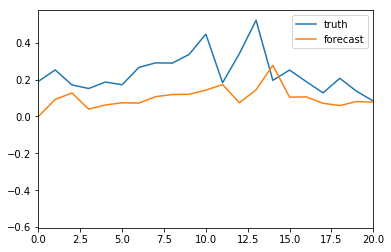

Lag 2
Trained using all months...
Truth_anom shape: (18432, 1199)
Forecast_anom shape: (18432, 1199)


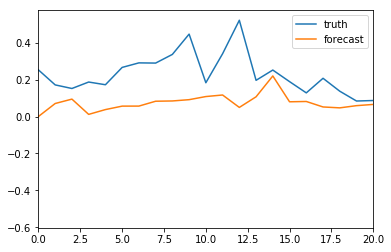

Lag 3
Trained using all months...
Truth_anom shape: (18432, 1198)
Forecast_anom shape: (18432, 1198)


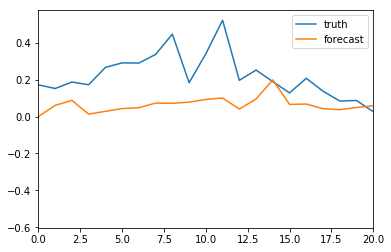

Lag 4
Trained using all months...
Truth_anom shape: (18432, 1197)
Forecast_anom shape: (18432, 1197)


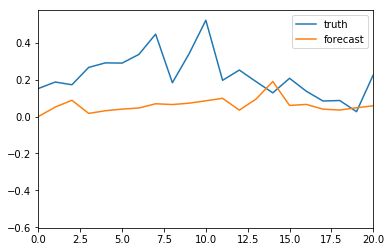

Lag 5
Trained using all months...
Truth_anom shape: (18432, 1196)
Forecast_anom shape: (18432, 1196)


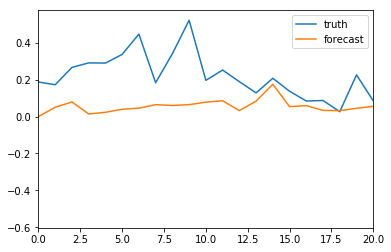

Lag 6
Trained using all months...
Truth_anom shape: (18432, 1195)
Forecast_anom shape: (18432, 1195)


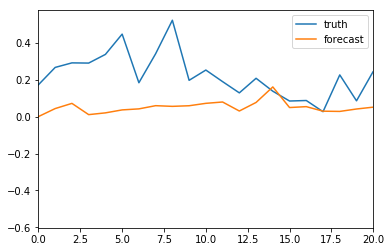

Loading from tos
Loading from t_millenium/tos_sfc_Omon_MPI-ESM-P_past1000_085001-184912.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(56320, 1200)
(56320, 1200)
-----------------------------------------------------
completed in 13.507846355438232 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (56320, 1200)
Forecast_anom shape: (56320, 1200)


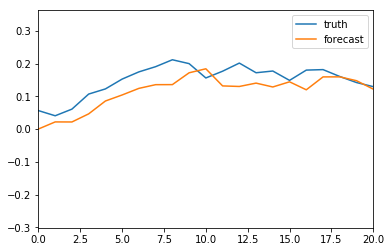

Lag 2
Trained using all months...
Truth_anom shape: (56320, 1199)
Forecast_anom shape: (56320, 1199)


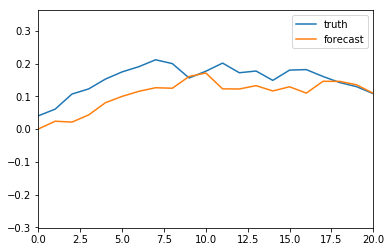

Lag 3
Trained using all months...
Truth_anom shape: (56320, 1198)
Forecast_anom shape: (56320, 1198)


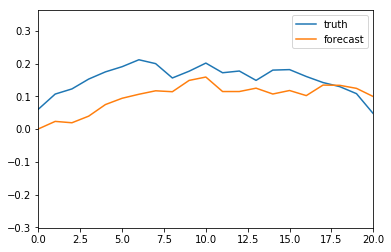

Lag 4
Trained using all months...
Truth_anom shape: (56320, 1197)
Forecast_anom shape: (56320, 1197)


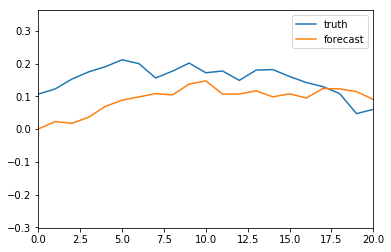

Lag 5
Trained using all months...
Truth_anom shape: (56320, 1196)
Forecast_anom shape: (56320, 1196)


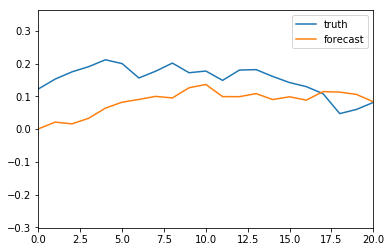

Lag 6
Trained using all months...
Truth_anom shape: (56320, 1195)
Forecast_anom shape: (56320, 1195)


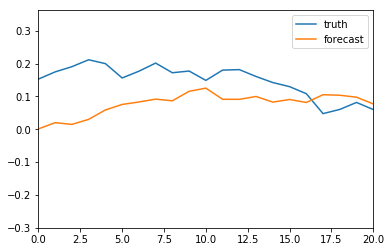

Loading from sit
Loading from ceData/MPI/sit_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(56320, 1200)
(56320, 1200)
-----------------------------------------------------
completed in 5.884464263916016 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (56320, 1200)
Forecast_anom shape: (56320, 1200)


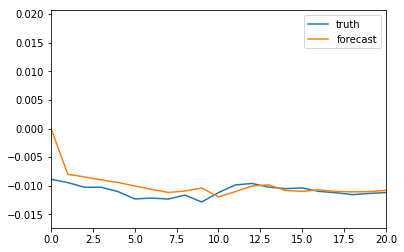

Lag 2
Trained using all months...
Truth_anom shape: (56320, 1199)
Forecast_anom shape: (56320, 1199)


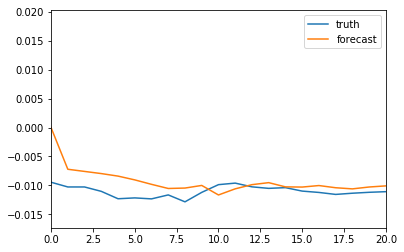

Lag 3
Trained using all months...
Truth_anom shape: (56320, 1198)
Forecast_anom shape: (56320, 1198)


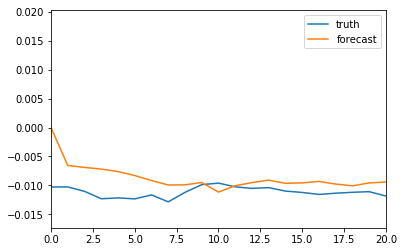

Lag 4
Trained using all months...
Truth_anom shape: (56320, 1197)
Forecast_anom shape: (56320, 1197)


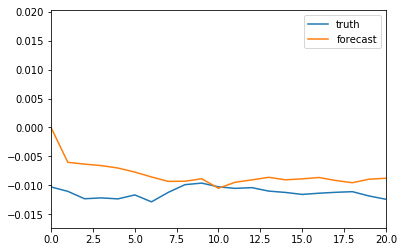

Lag 5
Trained using all months...
Truth_anom shape: (56320, 1196)
Forecast_anom shape: (56320, 1196)


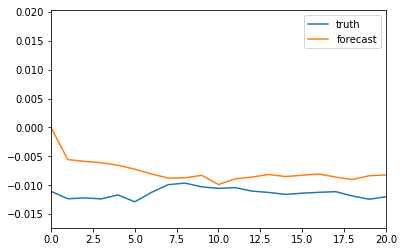

Lag 6
Trained using all months...
Truth_anom shape: (56320, 1195)
Forecast_anom shape: (56320, 1195)


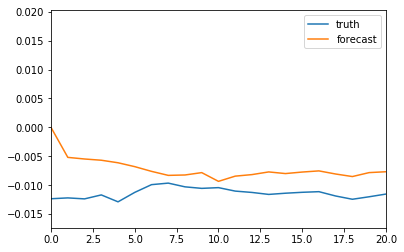

Loading from sic
Loading from ceData/MPI/sic_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 850 - 949
(1200,)
removing climotology...
detrending...
(56320, 1200)
(56320, 1200)
-----------------------------------------------------
completed in 5.795841217041016 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (56320, 1200)
Forecast_anom shape: (56320, 1200)


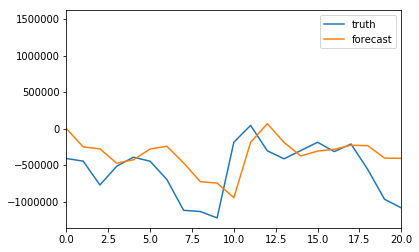

Lag 2
Trained using all months...
Truth_anom shape: (56320, 1199)
Forecast_anom shape: (56320, 1199)


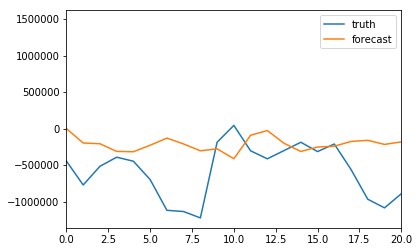

Lag 3
Trained using all months...
Truth_anom shape: (56320, 1198)
Forecast_anom shape: (56320, 1198)


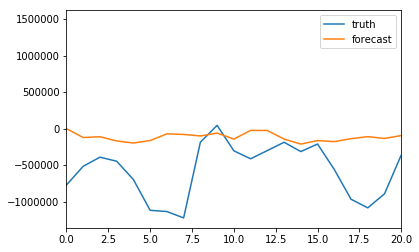

Lag 4
Trained using all months...
Truth_anom shape: (56320, 1197)
Forecast_anom shape: (56320, 1197)


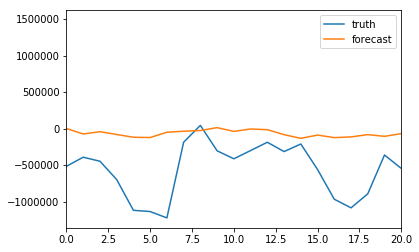

Lag 5
Trained using all months...
Truth_anom shape: (56320, 1196)
Forecast_anom shape: (56320, 1196)


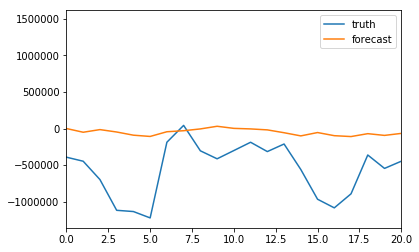

Lag 6
Trained using all months...
Truth_anom shape: (56320, 1195)
Forecast_anom shape: (56320, 1195)


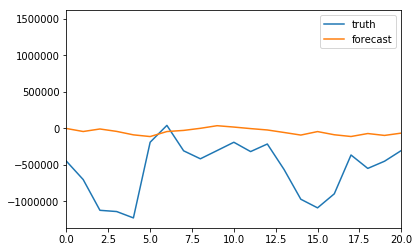

In [45]:
ar1f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

ar1cast_lags = rf.ar1_forecast_valid_by_lag(LIMd['P_train'], forecast['P_train_valid'], LIMd, exp_setup, 
                                            exp_setup['limvars'], month_names, ar1f_folder, forecast,
                                            iplot=True, save=master_save, save_decomp=False)

In [24]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = ('AR1_forecast_lagged_'+train_dsource+
#               '_ntrain_1850_1999_tas30_tos30_psl30_sit30_sic50_'+date_of_interest+'.pkl')

# ar1cast_lags = pickle.load(open(L_folder+L_filename, 'rb'))

## Validation by lag: 

In [46]:
if 'cmip6' in train_dsource: 
    tcmip='CMIP6'
else: 
    tcmip='CMIP5'

var = 'sic'
# start_tim = exp_setup['nyears_startvalid']
# end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                 str(forecast['var_dict_valid'][var]['time'][-1])[:4])

if 'hist' in train_dsource:
    texp = 'Historical'
elif 'lm' in train_dsource: 
    texp = 'LM'
elif 'ssp585' in train_dsource: 
    texp = 'SSP585'
    
if 'hist' in valid_dsource:
    vexp = 'Historical'
elif 'lm' in valid_dsource: 
    vexp = 'LM'
elif 'ssp585' in valid_dsource: 
    vexp = 'SSP585'
    
if 'cesm2' in train_dsource:
    tmod = 'CESM2'
elif 'mpi' in train_dsource: 
    tmod = 'MPI'
elif 'gfdl' in train_dsource: 
    tmod = 'GFDL'
elif 'ccsm4' in train_dsource: 
    tmod = 'CCSM4'
    
if 'cesm2' in valid_dsource:
    vmod = 'CESM2'
elif 'mpi' in valid_dsource: 
    vmod = 'MPI'
elif 'gfdl' in valid_dsource: 
    vmod = 'GFDL'
elif 'ccsm4' in valid_dsource: 
    vmod = 'CCSM4'

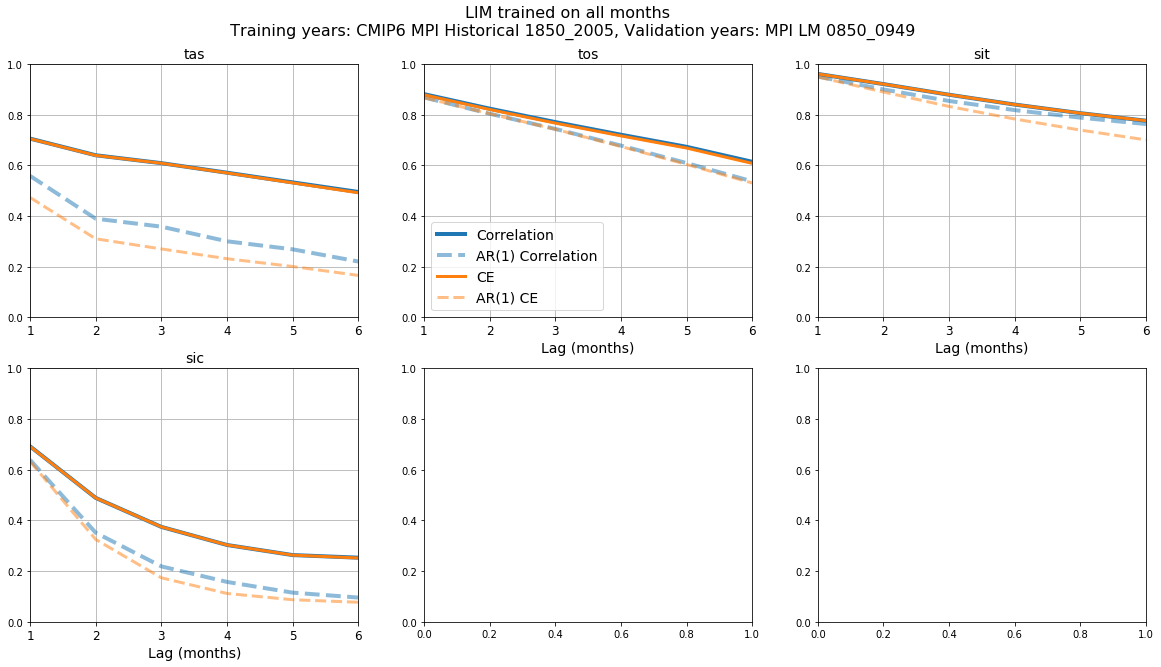

In [47]:
fig,axs = plt.subplots(2,3,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][1:]**2, 
               label='Correlation',linewidth=4)
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][1:],
               label='CE',linewidth=3.0)
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(1,6)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
#    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower left', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

In [48]:
forecast_validation_lags['validation_stats_lags']['tos']['corr_tot']**2,ar1cast_lags['validation_stats_ar1_lags']['tos']['corr_tot']**2

(array([0.93381874, 0.88050188, 0.82323472, 0.77026306, 0.72044644,
        0.67268471, 0.6136947 ]),
 array([0.86756525, 0.80327515, 0.74342798, 0.67771929, 0.60867089,
        0.5365995 , 0.        ]))

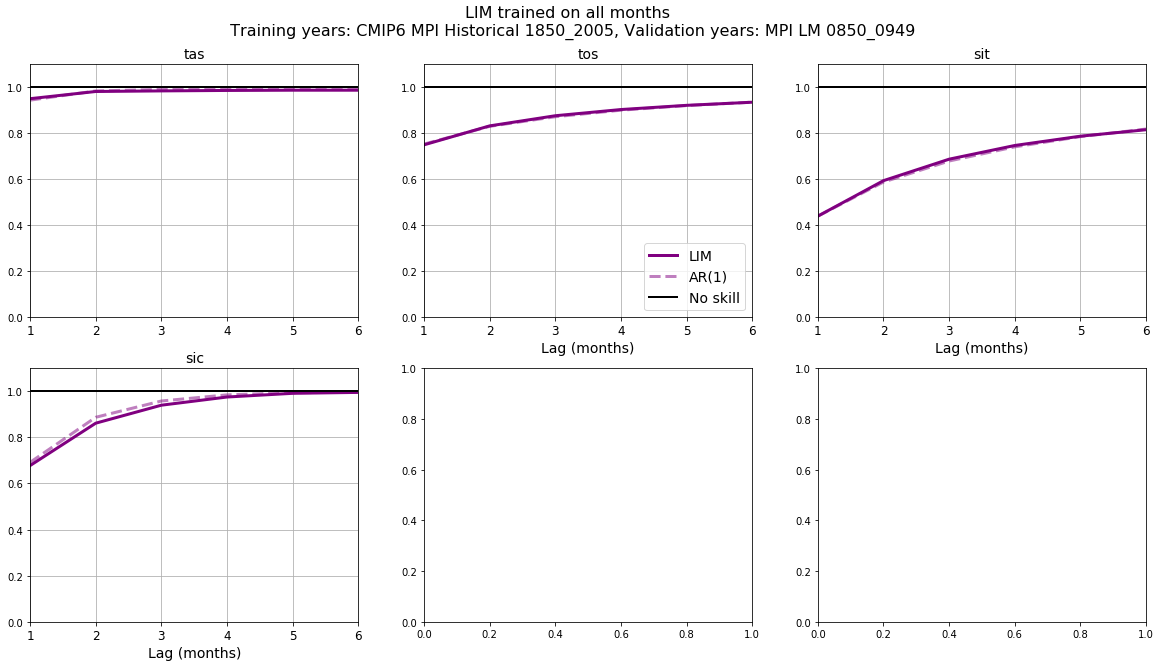

In [49]:
fig,axs = plt.subplots(2,3,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['gm_var_ratio'][1:], 
               label='LIM',linewidth=3.0, color='purple')
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_var_ratio'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xlim(1,6)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    
    ax[i].axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

## Validation by month: 

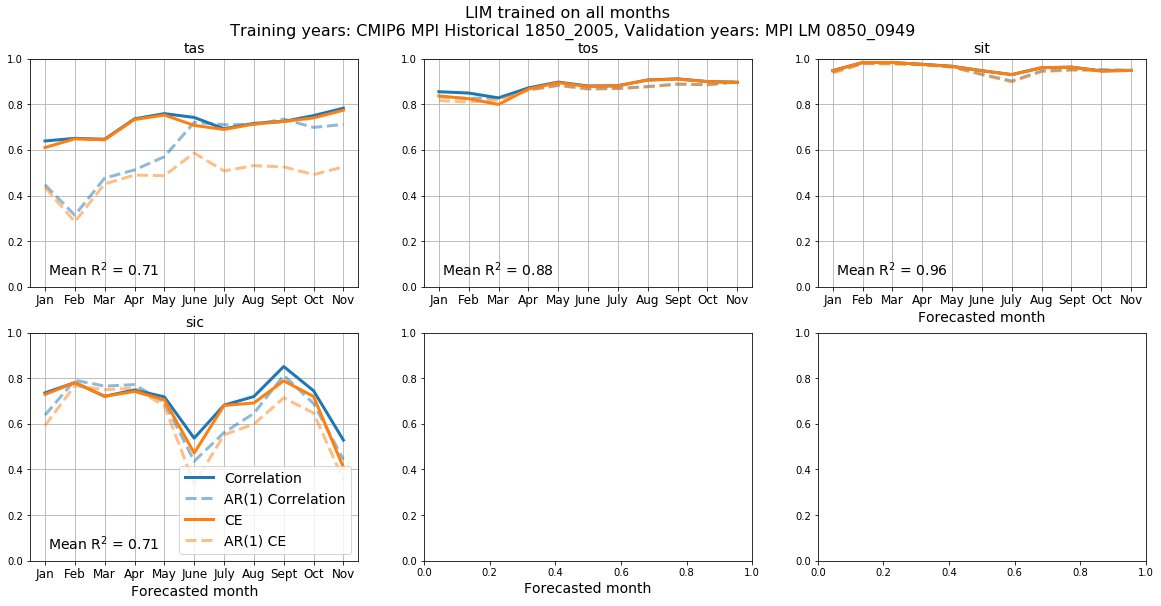

In [50]:
fig,axs = plt.subplots(2,3,figsize=(20,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(forecast_validation['validation_stats'][var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(ar1cast['validation_stats_ar1'][var]['corr_tot']**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(forecast_validation['validation_stats'][var]['ce_tot'],label='CE',linewidth=3.0)
    ax[i].plot(ar1cast['validation_stats_ar1'][var]['ce_tot'],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)#, rotation=45)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    mn = np.round(np.mean(forecast_validation['validation_stats'][var]['corr_tot']**2),2)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(mn)),fontsize=14)

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
# #                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)

else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[3].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[4].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.9)

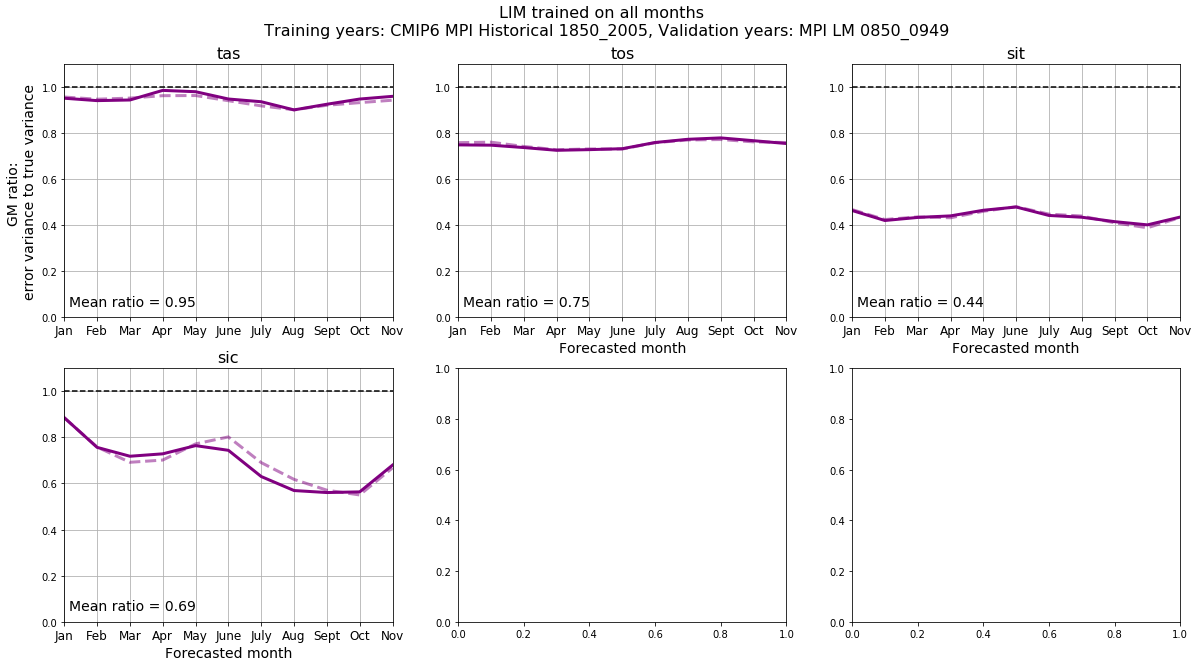

In [51]:
fig,axs = plt.subplots(2,3,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(forecast_validation['validation_stats'][var]['gm_var_ratio'],linewidth=3.0, color='purple')

    ax[i].plot(ar1cast['validation_stats_ar1'][var]['gm_var_ratio'],linewidth=3.0, color='purple', 
               linestyle='--', alpha=0.5)

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(forecast_validation['validation_stats'][var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)
    
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.9)
#plt.tight_layout()